In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

plt.style.use('dark_background')


In [14]:

df = pd.read_csv("../BTC_data.csv")

expected_cols = ['date','open','high','low','close',
                 'volume','SP500','GOLD','DXY']
print('Col Name: ', df.columns.tolist())

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

# Add technical indicators for better feature engineering
# Moving averages
df['BTC_MA_7'] = df['close'].rolling(window=7).mean()
df['BTC_MA_14'] = df['close'].rolling(window=14).mean()
df['BTC_MA_30'] = df['close'].rolling(window=30).mean()

# Momentum indicators
df['BTC_momentum_7'] = df['close'].pct_change(7)
df['BTC_momentum_14'] = df['close'].pct_change(14)

# Volatility (rolling std)
df['BTC_volatility_7'] = df['close'].rolling(window=7).std()
df['BTC_volatility_14'] = df['close'].rolling(window=14).std()

# RSI-like indicator (price position in recent range)
df['BTC_high_7'] = df['high'].rolling(window=7).max()
df['BTC_low_7'] = df['low'].rolling(window=7).min()
df['BTC_position'] = (df['close'] - df['BTC_low_7']) / (df['BTC_high_7'] - df['BTC_low_7'] + 1e-10)

# Volume momentum
df['BTC_volume_ma'] = df['volume'].rolling(window=7).mean()
df['BTC_volume_ratio'] = df['volume'] / (df['BTC_volume_ma'] + 1e-10)

# Rate of change
df['BTC_roc'] = df['close'].pct_change(1)

# External asset momentum
df['SP500_momentum'] = df['SP500'].pct_change(7)
df['GOLD_momentum'] = df['GOLD'].pct_change(7)
df['DXY_momentum'] = df['DXY'].pct_change(7)

# Drop rows with NaN from rolling calculations
df = df.dropna()

print(f"Data shape after feature engineering: {df.shape}")
df.tail()


Col Name:  ['date', 'open', 'high', 'low', 'close', 'volume', 'log_price', 'log_ret', 'ret_5d', 'ret_20d', 'vol_20d', 'mom_10d', 'sma10', 'sma20', 'sma50', 'SP500', 'SP500_log_price', 'SP500_lret', 'SP500_ret_5d', 'SP500_ret_20d', 'SP500_vol_20d', 'SP500_mom_10d', 'SP500_sma10', 'SP500_sma20', 'SP500_sma50', 'GOLD', 'GOLD_log_price', 'GOLD_lret', 'GOLD_ret_5d', 'GOLD_ret_20d', 'GOLD_vol_20d', 'GOLD_mom_10d', 'GOLD_sma10', 'GOLD_sma20', 'GOLD_sma50', 'DXY', 'DXY_log_price', 'DXY_lret', 'DXY_ret_5d', 'DXY_ret_20d', 'DXY_vol_20d', 'DXY_mom_10d', 'DXY_sma10', 'DXY_sma20', 'DXY_sma50', 'ret_1d_arith', 'y_price_next', 'y_log_price_next', 'y_ret_1d_next', 'y_log_ret_1d_next']
Data shape after feature engineering: (3148, 65)


,open,high,low,close,volume,log_price,log_ret,ret_5d,ret_20d,vol_20d,...,BTC_volatility_14,BTC_high_7,BTC_low_7,BTC_position,BTC_volume_ma,BTC_volume_ratio,BTC_roc,SP500_momentum,GOLD_momentum,DXY_momentum
date,,,,,,,,,,,,,,,,,,,,,
2025-11-20,91459.351562,93025.070312,86040.796875,86631.898438,9.797065e+10,11.369423,-0.054299,-0.097973,-0.234769,0.024977,...,5963.655513,99804.429688,86040.796875,0.042947,8.539630e+10,1.147247,-0.052851,-0.029496,-0.031145,0.009881
2025-11-21,86528.773438,87380.804688,80659.812500,85090.687500,1.291575e+11,11.351473,-0.017950,-0.101459,-0.257345,0.024708,...,6597.193911,96728.468750,80659.812500,0.275746,8.751217e+10,1.475881,-0.017790,-0.019471,-0.002667,0.009167
2025-11-22,85098.562500,85503.007812,83490.898438,84648.359375,4.079310e+10,11.346261,-0.005212,-0.084303,-0.267773,0.024414,...,7056.755663,96564.187500,80659.812500,0.250783,8.783965e+10,0.464404,-0.005198,-0.019471,-0.002667,0.009167
2025-11-23,84648.609375,88038.468750,84641.773438,86805.007812,5.808344e+10,11.371420,0.025159,-0.068385,-0.204927,0.025155,...,6807.531655,95928.367188,80659.812500,0.402474,8.598211e+10,0.675529,0.025478,-0.019471,-0.002667,0.009167
2025-11-24,86798.773438,89206.335938,85272.195312,88270.562500,7.443390e+10,11.388162,0.016742,-0.035561,-0.140544,0.024220,...,5976.017000,93745.078125,80659.812500,0.581627,8.316036e+10,0.895065,0.016883,0.004902,0.005801,0.005523


In [15]:
# Feature Columns and Target Column (including new technical indicators)
feature_cols = ['open','high','low','close',
                'volume','SP500','GOLD','DXY',
                'BTC_MA_7','BTC_MA_14','BTC_MA_30',
                'BTC_momentum_7','BTC_momentum_14',
                'BTC_volatility_7','BTC_volatility_14',
                'BTC_position','BTC_volume_ratio','BTC_roc',
                'SP500_momentum','GOLD_momentum','DXY_momentum']

# Create price change target (percentage return)
# Predicting price change is often better than predicting absolute price
df['BTC_price_change_pct'] = df['close'].pct_change(1)  # 1-day percentage return
df['BTC_prev_close'] = df['close'].shift(1)  # Previous day's close (needed to convert back)

# Drop first row which has NaN from shift/pct_change
df = df.dropna()

target_col = 'BTC_price_change_pct'  # Changed to predict price changes
prev_price_col = 'BTC_prev_close'    # Keep track of previous price for conversion

print(f"Total features: {len(feature_cols)}")
print(f"Target: {target_col} (1-day percentage return)")
print(f"Will convert predictions back to absolute prices using previous close")

X_all = df[feature_cols].values.astype(float)  
y_all = df[[target_col]].values.astype(float)  
prev_close_all = df[prev_price_col].values.astype(float)  # Previous prices for conversion

train_size = df.loc[: "2024-12-31"].shape[0]
test_size  = df.loc["2025-01-01":].shape[0]

print('\nTotal samples:', len(df))
print('Train size   :', train_size)
print('Test size    :', test_size)

X_train_raw = X_all[:train_size]
X_test_raw  = X_all[train_size:]
y_train_raw = y_all[:train_size]
y_test_raw  = y_all[train_size:]
prev_close_train = prev_close_all[:train_size]
prev_close_test = prev_close_all[train_size:]

# Store actual close prices for comparison
actual_close_train = df['close'].values[:train_size]
actual_close_test = df['close'].values[train_size:]

X_train_raw.shape, X_test_raw.shape, y_train_raw.shape, y_test_raw.shape


Total features: 21
Target: BTC_price_change_pct (1-day percentage return)
Will convert predictions back to absolute prices using previous close

Total samples: 3147
Train size   : 2819
Test size    : 328


((2819, 21), (328, 21), (2819, 1), (328, 1))

In [16]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_all_scaled   = scaler_X.transform(X_all)

y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_all_scaled   = scaler_y.transform(y_all)

X_train_scaled.shape, X_all_scaled.shape, y_train_scaled.shape, y_all_scaled.shape


((2819, 21), (3147, 21), (2819, 1), (3147, 1))

In [17]:
time_steps = 30

def create_sequences_XGBoost(X, y, time_steps):
    """
    Create sequences for XGBoost by flattening time windows.
    Each sample becomes a flat feature vector of shape (time_steps * n_features,)
    Also includes statistical features from the time window for better learning.
    """
    X_list, y_list = [], []
    for i in range(time_steps, len(X)):
        # Get the time window
        window = X[i-time_steps:i]
        
        # Flatten the time window
        X_flat = window.flatten()
        
        # Add statistical features from the window (mean, std, min, max of each feature)
        stats_features = []
        for feat_idx in range(window.shape[1]):
            feat_window = window[:, feat_idx]
            stats_features.extend([
                feat_window.mean(),      # Mean
                feat_window.std(),       # Std deviation
                feat_window.min(),       # Min
                feat_window.max(),       # Max
                feat_window[-1] - feat_window[0],  # Change over window
                feat_window[-1] / (feat_window[0] + 1e-10)  # Ratio
            ])
        
        # Combine flattened window + statistical features
        X_combined = np.concatenate([X_flat, np.array(stats_features)])
        X_list.append(X_combined)
        y_list.append(y[i])
    
    return np.array(X_list), np.array(y_list)

X_seq, y_seq = create_sequences_XGBoost(X_all_scaled, y_all_scaled, time_steps)
print('X_seq:', X_seq.shape, 'y_seq:', y_seq.shape)

split_idx = train_size - time_steps
x_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
x_test  = X_seq[split_idx:]
y_test  = y_seq[split_idx:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape


X_seq: (3117, 756) y_seq: (3117, 1)


((2789, 756), (2789, 1), (328, 756), (328, 1))

In [18]:
# Flatten y_train and y_test for XGBoost (it expects 1D array)
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

print('n_features (after flattening):', x_train.shape[1])
print('Training samples:', x_train.shape[0])
print('Test samples:', x_test.shape[0])

# Initialize XGBoost Regressor with optimized parameters for time series
# Parameters tuned to better capture volatility and trends
model = xgb.XGBRegressor(
    n_estimators=500,       # High number of trees for better learning
    max_depth=10,           # Deeper trees to capture complex patterns
    learning_rate=0.03,     # Higher learning rate for faster adaptation
    subsample=0.9,          # Use more data for each tree
    colsample_bytree=0.9,   # Use more features
    colsample_bylevel=0.9,  # Column sampling at each level
    min_child_weight=1,     # Lower threshold for splits (more sensitive)
    gamma=0,                # No minimum loss reduction (allow more splits)
    reg_alpha=0.05,         # Light L1 regularization
    reg_lambda=0.5,         # Light L2 regularization (less regularization = more sensitivity)
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='rmse',
    objective='reg:squarederror',
    booster='gbtree'
)

print("XGBoost Model Configuration (Optimized for Time Series):")
print(f"  - n_estimators: {model.n_estimators}")
print(f"  - max_depth: {model.max_depth}")
print(f"  - learning_rate: {model.learning_rate}")
print(f"  - subsample: {model.subsample}")
print(f"  - colsample_bytree: {model.colsample_bytree}")
print(f"  - min_child_weight: {model.min_child_weight}")
print(f"  - gamma: {model.gamma}")
print(f"  - reg_alpha (L1): {model.reg_alpha}")
print(f"  - reg_lambda (L2): {model.reg_lambda}")


n_features (after flattening): 756
Training samples: 2789
Test samples: 328
XGBoost Model Configuration (Optimized for Time Series):
  - n_estimators: 500
  - max_depth: 10
  - learning_rate: 0.03
  - subsample: 0.9
  - colsample_bytree: 0.9
  - min_child_weight: 1
  - gamma: 0
  - reg_alpha (L1): 0.05
  - reg_lambda (L2): 0.5


In [19]:
# Train the model with validation monitoring
# Monitor training to prevent overfitting while allowing the model to learn complex patterns
model.fit(
    x_train, y_train_flat,
    eval_set=[(x_train, y_train_flat), (x_test, y_test_flat)],
    verbose=50  # Print every 50 iterations
)

print(f"\nTraining completed with {model.n_estimators} estimators")


[0]	validation_0-rmse:0.05961	validation_1-rmse:0.03588
[50]	validation_0-rmse:0.04211	validation_1-rmse:0.03781
[100]	validation_0-rmse:0.02548	validation_1-rmse:0.03830
[150]	validation_0-rmse:0.01516	validation_1-rmse:0.03849
[200]	validation_0-rmse:0.00911	validation_1-rmse:0.03875
[250]	validation_0-rmse:0.00590	validation_1-rmse:0.03882
[300]	validation_0-rmse:0.00419	validation_1-rmse:0.03883
[350]	validation_0-rmse:0.00321	validation_1-rmse:0.03885
[400]	validation_0-rmse:0.00261	validation_1-rmse:0.03886
[450]	validation_0-rmse:0.00221	validation_1-rmse:0.03887
[499]	validation_0-rmse:0.00194	validation_1-rmse:0.03887

Training completed with 500 estimators


In [20]:
# Model predicts price changes (percentage returns)
train_pred_change_scaled = model.predict(x_train).reshape(-1, 1)
test_pred_change_scaled  = model.predict(x_test).reshape(-1, 1)

# Inverse transform to get actual percentage returns
train_pred_change = scaler_y.inverse_transform(train_pred_change_scaled)
test_pred_change  = scaler_y.inverse_transform(test_pred_change_scaled)
y_train_change_actual = scaler_y.inverse_transform(y_train)
y_test_change_actual  = scaler_y.inverse_transform(y_test)

# Convert predicted price changes back to absolute prices
# predicted_price = previous_price * (1 + predicted_return)
# Get previous prices for the sequences (need to align with sequence indices)
prev_close_train_seq = prev_close_train[time_steps:]
prev_close_test_seq = prev_close_test

train_pred_price = prev_close_train_seq * (1 + train_pred_change.flatten())
test_pred_price = prev_close_test_seq * (1 + test_pred_change.flatten())

# Get actual prices for comparison
y_train_actual = actual_close_train[time_steps:]
y_test_actual = actual_close_test

# Calculate metrics on absolute prices
mae = mean_absolute_error(y_test_actual, test_pred_price)
rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred_price))
print('Test MAE (on absolute prices):', mae)
print('Test RMSE (on absolute prices):', rmse)
print('\nNote: Model predicts price changes (%), then converts to absolute prices')


Test MAE (on absolute prices): 1702.8270735888425
Test RMSE (on absolute prices): 2336.13514089149

Note: Model predicts price changes (%), then converts to absolute prices


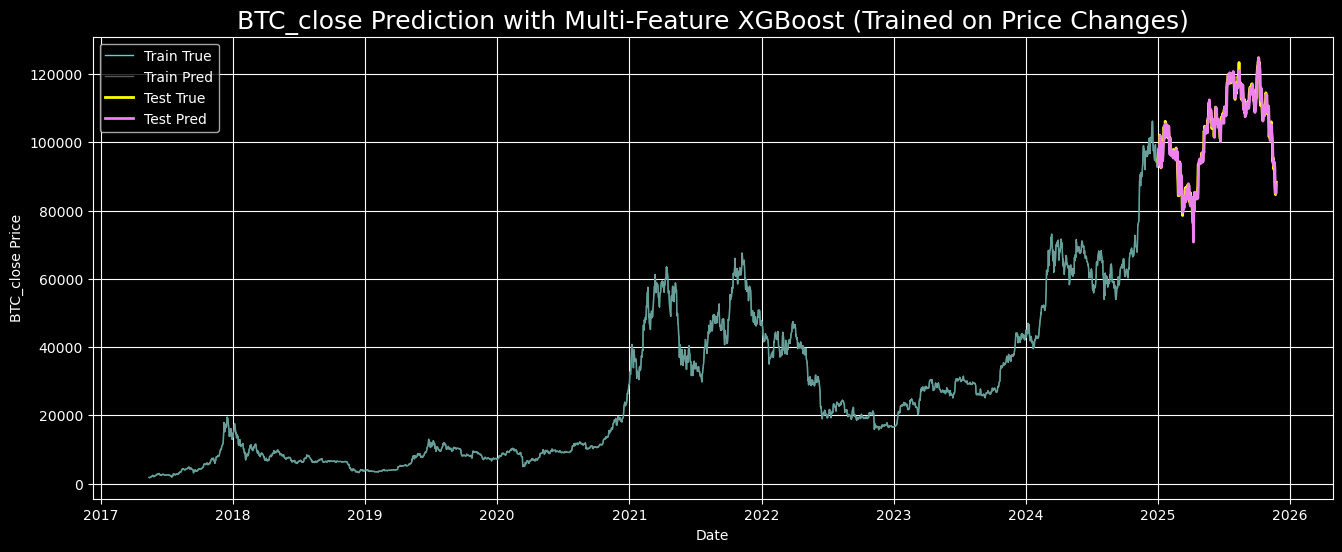

In [21]:
plt.figure(figsize=(16, 6))
plt.title('BTC_close Prediction with Multi-Feature XGBoost (Trained on Price Changes)', fontsize=18)

idx_all = df.index
idx_train = idx_all[time_steps:train_size]
idx_test  = idx_all[train_size:]

plt.plot(idx_train, y_train_actual, label='Train True', color='turquoise', linewidth=1)
plt.plot(idx_train, train_pred_price, label='Train Pred', color='gray', linewidth=1, alpha=0.7)

plt.plot(idx_test, y_test_actual, label='Test True', color='yellow', linewidth=2)
plt.plot(idx_test, test_pred_price, label='Test Pred', color='violet', linewidth=2)

plt.xlabel('Date')
plt.ylabel('BTC_close Price')
plt.legend()
plt.grid(True)
plt.show()


Total features: 756
Feature names created: 756


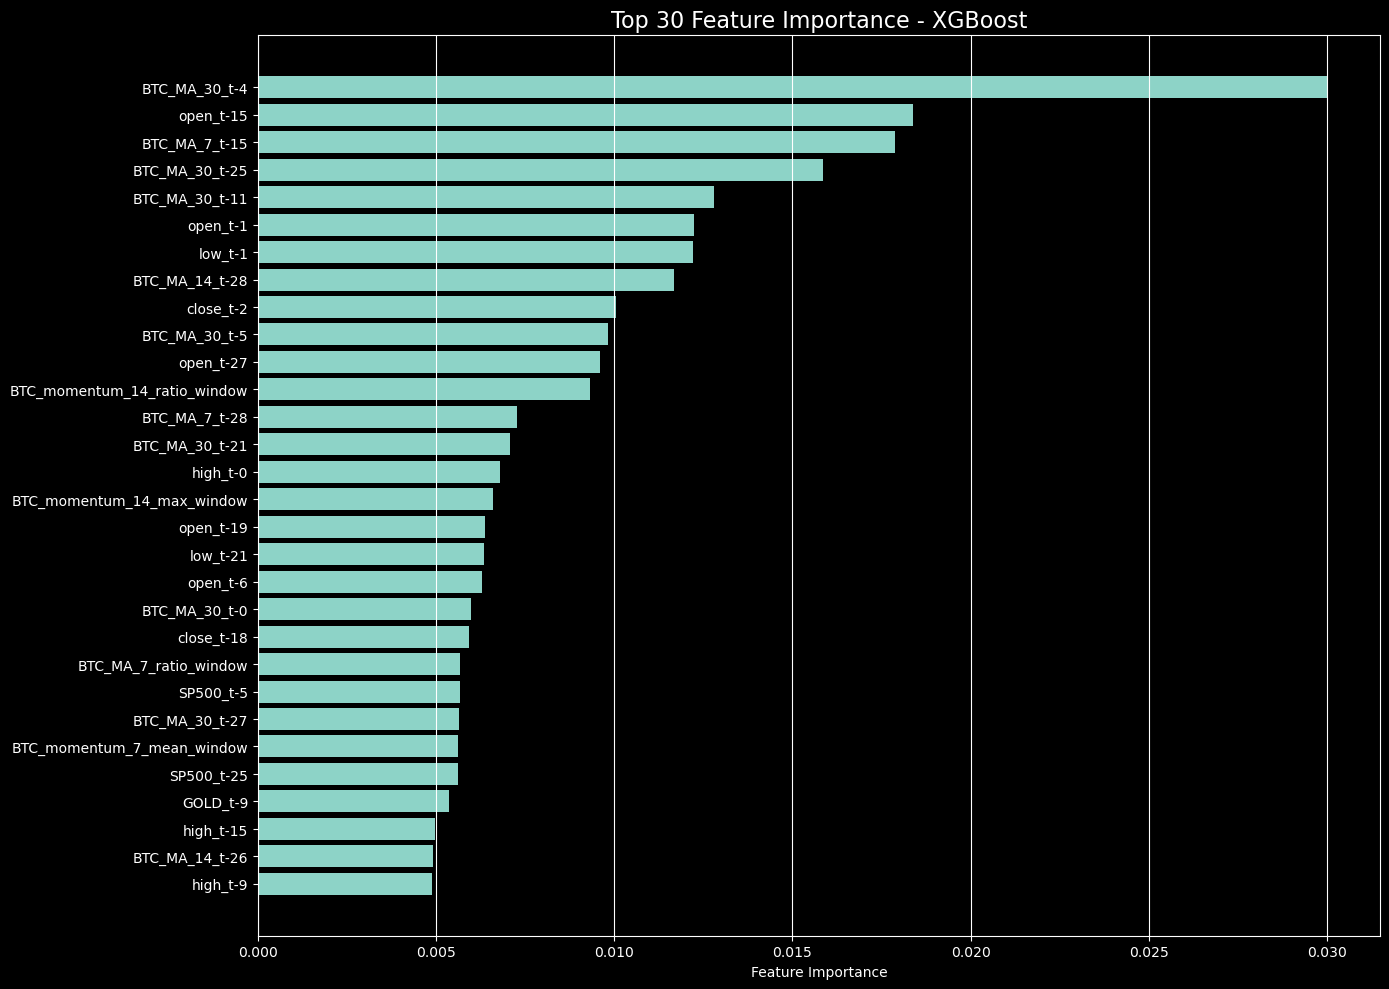

In [22]:
# Feature importance plot
feature_importance = model.feature_importances_

# Create feature names for all features
# First, names for flattened time window features
n_features_per_timestep = len(feature_cols)
feature_names = []
for t in range(time_steps):
    for f in feature_cols:
        feature_names.append(f'{f}_t-{time_steps-t-1}')

# Then, names for statistical features (mean, std, min, max, change, ratio)
stat_names = ['mean', 'std', 'min', 'max', 'change', 'ratio']
for f in feature_cols:
    for stat in stat_names:
        feature_names.append(f'{f}_{stat}_window')

# Verify we have the right number of feature names
total_features = len(feature_importance)
print(f"Total features: {total_features}")
print(f"Feature names created: {len(feature_names)}")

# Sort by importance
indices = np.argsort(feature_importance)[::-1]
top_n = 30  # Show top 30 features

# Only use indices that are within bounds
valid_indices = [i for i in indices[:top_n] if i < len(feature_names)]
if len(valid_indices) < top_n:
    print(f"Warning: Only {len(valid_indices)} feature names available, showing fewer features")

plt.figure(figsize=(14, 10))
plt.title(f'Top {len(valid_indices)} Feature Importance - XGBoost', fontsize=16)
plt.barh(range(len(valid_indices)), feature_importance[valid_indices])
plt.yticks(range(len(valid_indices)), [feature_names[i] for i in valid_indices])
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [23]:
# Calculate additional metrics on absolute prices
from sklearn.metrics import r2_score

train_r2 = r2_score(y_train_actual, train_pred_price)
test_r2 = r2_score(y_test_actual, test_pred_price)
train_mae = mean_absolute_error(y_train_actual, train_pred_price)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_pred_price))

print('Training Metrics (Absolute Prices):')
print(f'  MAE : {train_mae:.2f}')
print(f'  RMSE: {train_rmse:.2f}')
print(f'  R²  : {train_r2:.4f}')
print()
print('Test Metrics (Absolute Prices):')
print(f'  MAE : {mae:.2f}')
print(f'  RMSE: {rmse:.2f}')
print(f'  R²  : {test_r2:.4f}')
print()
print('\nModel trained on price changes (%) then converted to absolute prices')
print('This approach is more stable and better for time series forecasting')


Training Metrics (Absolute Prices):
  MAE : 18.93
  RMSE: 37.33
  R²  : 1.0000

Test Metrics (Absolute Prices):
  MAE : 1702.83
  RMSE: 2336.14
  R²  : 0.9590


Model trained on price changes (%) then converted to absolute prices
This approach is more stable and better for time series forecasting


In [24]:
pred_result = pd.read_csv("Predict.csv", parse_dates=["date"])
pred_result = pred_result.set_index("date") 
pred_result['BTC_LSTM'] = test_pred_price.flatten()
pred_result.to_csv("Predict.csv", index_label="date")